In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/work/scripts/util')
from output import load_trsc_dataframe
import os
import output as ou
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

In [2]:
SA_path = '/data/workflows/BONA_black_spruce_SWC_SA/'
#SA_path = '/data/workflows/BONA_birch_SWC_SA/'
run_dirs=[os.path.join(SA_path, f) for f in os.listdir(SA_path) if ('sample' in f) and not ('.' in f)]

varlist = ['LAYERDEPTH', 'LAYERDZ', 'LAYERTYPE', 'TLAYER', 'LWCLAYER']
cell_x_coord = 0
cell_y_coord = 0

# WTT2, WTT3, DF2 - birch

# WTT1 - black spruce


In [3]:
depthlist = [0.15,0.4]

def get_lwclayer_tlayer(depthlist, run_dir, var):
    
    ### read the netcdf output files and compute year from the time dimension
    data = xr.open_dataset(f'{run_dir}/output/{var}_monthly_tr.nc')
    data = data.to_dataframe()
    data.reset_index(inplace=True)
    data.dtypes
    data['time'] = data['time'].astype('|S80')
    data['time'] = data['time'].astype('|datetime64[ns]')
    data['month'] = data['time'].dt.month
    data['year'] = data['time'].dt.year
    data = data.sort_values(['time','x','y','layer'])


    ### read the netcdf output files on soil structure and compute year from the time dimension
    dz = xr.open_dataset(f'{run_dir}/output/LAYERDZ_monthly_tr.nc')
    dz = dz.to_dataframe()
    dz.reset_index(inplace=True)
    dz.dtypes
    dz['time'] = dz['time'].astype('|S80')
    dz['time'] = dz['time'].astype('|datetime64[ns]')
    dz['month'] = dz['time'].dt.month
    dz['year'] = dz['time'].dt.year
    dz = dz.sort_values(['time','x','y','layer'])

    ### read the netcdf output files on soil structure and compute year from the time dimension
    lt = xr.open_dataset(f'{run_dir}/output/LAYERTYPE_monthly_tr.nc')
    lt = lt.to_dataframe()
    lt.reset_index(inplace=True)
    lt.dtypes
    lt['time'] = lt['time'].astype('|S80')
    lt['time'] = lt['time'].astype('|datetime64[ns]')
    lt['month'] = lt['time'].dt.month
    lt['year'] = lt['time'].dt.year
    lt = lt.sort_values(['time','x','y','layer'])
    dz=pd.merge(dz, lt[['LAYERTYPE', 'time', 'x', 'y', 'layer']], on=['time','x','y','layer'])


    ### compute the depth of the bottom of every layers
    dz['z'] = dz.groupby(['time','x','y'])['LAYERDZ'].cumsum(axis=0)
    
    ### loop through the list of depths of reference to compute the soil variable at that depth via linear interpolation
    stdz = []
    for i in range(len(depthlist)):
        dpth = depthlist[i]
        print("depth:", dpth,"m")
        # extract the top and bottom layers the closest to the depth of reference
        dz['diff'] = dz['z']-float(dpth)
        top = dz.loc[dz[(dz['diff'] <= 0)].groupby(['time','x','y'])['diff'].idxmax()]
        bot = dz.loc[dz[(dz['diff'] >= 0)].groupby(['time','x','y'])['diff'].idxmin()]
        # select the variable value for each of these top and bottom layers
        datatop = pd.merge(data, top[['year','month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month', 'x','y'])
        datatop = datatop[datatop['z'].notna()]
        datatop = datatop.rename(columns={"layer": "layertop", var: var+"top", "LAYERDZ": "dztop", "z": "ztop", "LAYERTYPE": "typetop"})
        databot = pd.merge(data, bot[['year', 'month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month' , 'x','y'])
        databot = databot[databot['z'].notna()]
        databot = databot.rename(columns={"layer": "layerbot", var: var+"bot", "LAYERDZ": "dzbot", "z": "zbot", "LAYERTYPE": "typebot"})
        # merge the data to do the linear interpolation
        datastdz = pd.merge(datatop, databot, how="outer", on=['time','year', 'month', 'x','y'])
        datastdz['a'] = (datastdz[var+"top"] - datastdz[var+"bot"]) / (datastdz['ztop'] - datastdz['zbot'])
        datastdz['b'] = datastdz[var+"top"] - (datastdz['a'] * datastdz['ztop'])
        datastdz[var] = (datastdz['a'] * float(dpth)) + datastdz['b']
        datastdz[var+'_top'] = datastdz[var+"top"]
        datastdz[var+'_bot'] = datastdz[var+"bot"]
        datastdz['z'] = float(dpth)
        datastdz['layer'] = i
        datastdz['type'] = datastdz['typebot']
        datastdz = datastdz[['time','x','y','layer','z','type',var, var+'_top', var+'_bot']]
        stdz.append(datastdz)

    stdz = pd.concat(stdz)
    
    return stdz

In [4]:
lwc_layers = []
t_layers = []
sample_dfs=[]
for d in run_dirs:
    if 'GPP_monthly_tr.nc' in os.listdir(os.path.join(d, 'output')):
        sample = int(d.split('/')[-1].split('_')[-1])
        TLAYER = ou.load_trsc_dataframe(var ='TLAYER', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0]
        LAYERDEPTH = ou.load_trsc_dataframe(var ='LAYERDEPTH', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0]
        LAYERDZ = ou.load_trsc_dataframe(var ='LAYERDZ', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0]
        GPP = ou.load_trsc_dataframe(var ='GPP', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0][0]
        ALD = ou.load_trsc_dataframe(var ='ALD', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0][0]
        RH = ou.load_trsc_dataframe(var ='RH', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0][0]
        ALD.columns=['ALD']
        sample_df = pd.DataFrame({'date': GPP.index, 'sample': [sample]*len(GPP), #'LWCLAYER': LWCLAYER, 'TLAYER': TLAYER, 'LAYERDEPTH': LAYERDEPTH, 'LAYERDZ': LAYERDZ,
                                  'GPP': GPP, 'RH':RH})
        sample_df = pd.merge(sample_df, ALD, how='left', left_on='date', right_index=True)
        sample_dfs.append(sample_df)
        
        LWCLAYER = get_lwclayer_tlayer(depthlist, d, 'LWCLAYER')
        LWCLAYER['sample'] = sample
        lwc_layers.append(LWCLAYER)
        
        TLAYER = get_lwclayer_tlayer(depthlist, d, 'TLAYER')
        TLAYER['sample'] = sample
        t_layers.append(TLAYER)
        
sample_dfs=pd.concat(sample_dfs)
lwc_layers=pd.concat(lwc_layers)
t_layers=pd.concat(t_layers)

Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000038/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000038/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000038/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000038/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000038/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000038/output/RH_monthly_tr.nc
depth: 0.15 m
depth: 0.4 m
depth: 0.15 m
depth: 0.4 m
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000040/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000040/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000040/output/LAYERDZ_monthly_tr.nc
Trying to open:  /da

depth: 0.15 m
depth: 0.4 m
depth: 0.15 m
depth: 0.4 m
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000035/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000035/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000035/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000035/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000035/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000035/output/RH_monthly_tr.nc
depth: 0.15 m
depth: 0.4 m
depth: 0.15 m
depth: 0.4 m
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000001/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000001/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_00000

depth: 0.15 m
depth: 0.4 m
depth: 0.15 m
depth: 0.4 m
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000013/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000013/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000013/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000013/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000013/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000013/output/RH_monthly_tr.nc
depth: 0.15 m
depth: 0.4 m
depth: 0.15 m
depth: 0.4 m
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000017/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000017/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_00000

depth: 0.15 m
depth: 0.4 m
depth: 0.15 m
depth: 0.4 m
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000008/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000008/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000008/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000008/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000008/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000008/output/RH_monthly_tr.nc
depth: 0.15 m
depth: 0.4 m
depth: 0.15 m
depth: 0.4 m
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000025/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_000000025/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/BONA_black_spruce_SWC_SA/sample_00000

In [5]:
sample_dfs['year'] = sample_dfs['date'].dt.year
sample_dfs['month'] = sample_dfs['date'].dt.month
sample_dfs = sample_dfs.loc[sample_dfs['year']>=2017]
sample_dfs.columns = ['date', 'sample', 'GPP', 'RH', 'ALD', 'year', 'month']

lwc_layers['year'] = lwc_layers['time'].dt.year
lwc_layers['month'] = lwc_layers['time'].dt.month
lwc_layers = lwc_layers.loc[lwc_layers['year']>=2017]

t_layers['year'] = t_layers['time'].dt.year
t_layers['month'] = t_layers['time'].dt.month
t_layers = t_layers.loc[t_layers['year']>=2017]

In [6]:
lwc_layers

,time,x,y,layer,z,type,LWCLAYER,LWCLAYER_top,LWCLAYER_bot,sample,year,month
1416,2017-01-30,0,0,0,0.15,2.0,0.000000,0.000000,0.000000,38,2017,1
1417,2017-03-02,0,0,0,0.15,2.0,0.000000,0.000000,0.000000,38,2017,3
1418,2017-03-02,0,0,0,0.15,2.0,0.000000,0.000000,0.000000,38,2017,3
1419,2017-03-02,0,0,0,0.15,2.0,0.000000,0.000000,0.000000,38,2017,3
1420,2017-03-02,0,0,0,0.15,2.0,0.000000,0.000000,0.000000,38,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1591,2022-12-01,0,0,1,0.40,3.0,0.441693,0.439165,0.455484,23,2022,12
1592,2022-12-31,0,0,1,0.40,3.0,0.435799,0.432190,0.455484,23,2022,12
1593,2022-12-31,0,0,1,0.40,3.0,0.435799,0.432190,0.455484,23,2022,12
1594,2022-12-31,0,0,1,0.40,3.0,0.435799,0.432190,0.455484,23,2022,12


In [7]:
path_to_tripod_data = '/data/comparison_data/BONA_Tripod_SM_TSoil.xlsx'

In [8]:
tripod_data = pd.read_excel(path_to_tripod_data, sheet_name='Long', parse_dates = ['Date'])
tripod_data = tripod_data.replace('NAN', np.nan)

In [9]:
tripod_data['month'] = tripod_data['Date'].dt.month
tripod_data['year'] = tripod_data['Date'].dt.year
tripod_data_monthly = tripod_data.groupby(by=['Location', 'year', 'month']).mean().reset_index()
tripod_data_monthly['day'] = 1
tripod_data_monthly['m_y'] = pd.to_datetime(tripod_data_monthly[['year', 'month', 'day']])

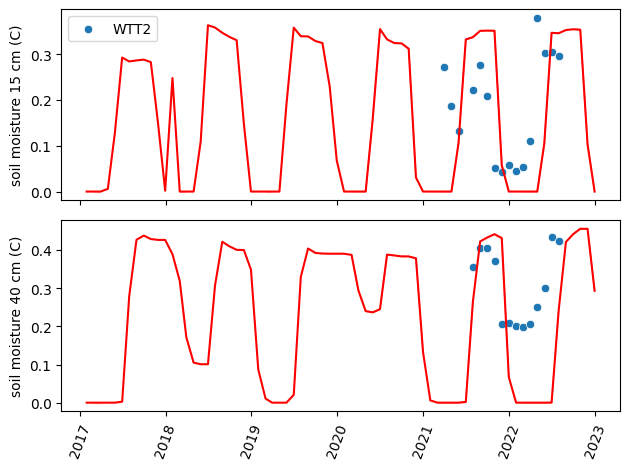

In [41]:
fig, axes = plt.subplots(2, 1, sharex=True)

#sns.lineplot(data=lwc_layers[lwc_layers['z']==.15], x='time', y='LWCLAYER', hue='sample', legend=False, ax=axes[0], alpha=0.3)
sns.lineplot(data=lwc_layers[(lwc_layers['z']==.15) & (lwc_layers['sample']==35)], x='time', y='LWCLAYER', color='red', ax=axes[0])

#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT3'], label='WTT3', 
#             x='m_y', y = 'soil_moisture_15cm(%)', ax=axes[0])
#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT2'], label='WTT2', 
#             x='m_y', y = 'soil_moisture_15cm(%)', ax=axes[0])
sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT1'], label='WTT2', 
             x='m_y', y = 'soil_moisture_15cm(%)', ax=axes[0])


#sns.lineplot(data=lwc_layers[lwc_layers['z']==.4], x='time', y='LWCLAYER', hue='sample', legend=False, ax=axes[1], alpha=0.3)
sns.lineplot(data=lwc_layers[(lwc_layers['z']==.4) & (lwc_layers['sample']==35)], x='time', y='LWCLAYER', color='red', ax=axes[1])


#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT3'], 
#             x='m_y', y = 'soil_moisture_40cm(%)', ax=axes[1])
#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT2'], 
#             x='m_y', y = 'soil_moisture_40cm(%)', ax=axes[1])
sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT1'], 
             x='m_y', y = 'soil_moisture_40cm(%)', ax=axes[1])

plt.xticks(rotation=70)

plt.xlabel('')
axes[0].set_ylabel('soil moisture 15 cm (C)')
axes[1].set_ylabel('soil moisture 40 cm (C)')

plt.xticks(rotation=70)


fig.tight_layout()

plt.savefig('BONA_SWC_SA_LWC_soil.jpg', dpi=300)

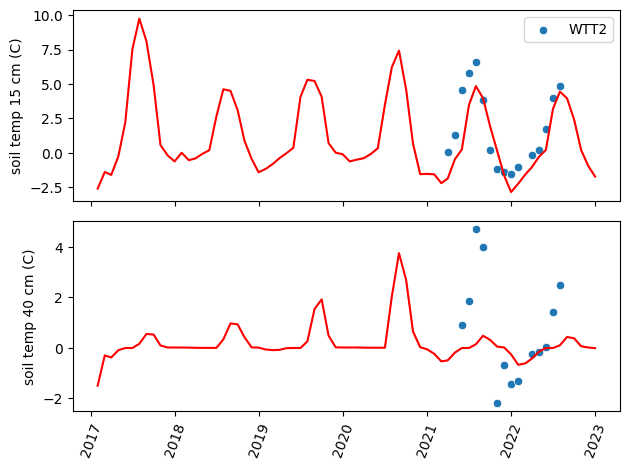

In [46]:
fig, axes = plt.subplots(2, 1, sharex=True)

#sns.lineplot(data=t_layers[t_layers['z']==.15], x='time', y='TLAYER', hue='sample', legend=False, alpha = 0.3, ax=axes[0])
sns.lineplot(data=t_layers[(t_layers['z']==.15) & (t_layers['sample']==35)], x='time', y='TLAYER', color='red', ax=axes[0])

#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT3'], label='WTT3', 
#             x='m_y', y = 'soil_temp_15cm(°C)', ax=axes[0])
#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT2'], label='WTT2',
#             x='m_y', y = 'soil_temp_15cm(°C)', ax=axes[0])
sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT1'], label='WTT2',
             x='m_y', y = 'soil_temp_15cm(°C)', ax=axes[0])


#sns.lineplot(data=t_layers[t_layers['z']==.4], x='time', y='TLAYER', hue='sample', alpha=0.3, ax=axes[1], legend=False)
sns.lineplot(data=t_layers[(t_layers['z']==.4) & (t_layers['sample']==35)], x='time', y='TLAYER', color='red', ax=axes[1])
#sns.lineplot(data=t_layers[(t_layers['z']==.4) & (t_layers['sample']==20)], x='time', y='TLAYER_top', color='red', ax=axes[1])
#sns.lineplot(data=t_layers[(t_layers['z']==.4) & (t_layers['sample']==20)], x='time', y='TLAYER_bot', color='red', ax=axes[1])

#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT3'], 
#             x='m_y', y = 'soil_temp_40cm(°C)', ax=axes[1])
#sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT2'], 
#             x='m_y', y = 'soil_temp_40cm(°C)', ax=axes[1])
sns.scatterplot(tripod_data_monthly[tripod_data_monthly['Location']=='WTT1'], 
             x='m_y', y = 'soil_temp_40cm(°C)', ax=axes[1])


plt.xlabel('')
axes[0].set_ylabel('soil temp 15 cm (C)')
axes[1].set_ylabel('soil temp 40 cm (C)')

plt.xticks(rotation=70)


fig.tight_layout()

plt.savefig('BONA_SWC_SA_T_soil.jpg', dpi=300)

<AxesSubplot:xlabel='year', ylabel='ALD'>

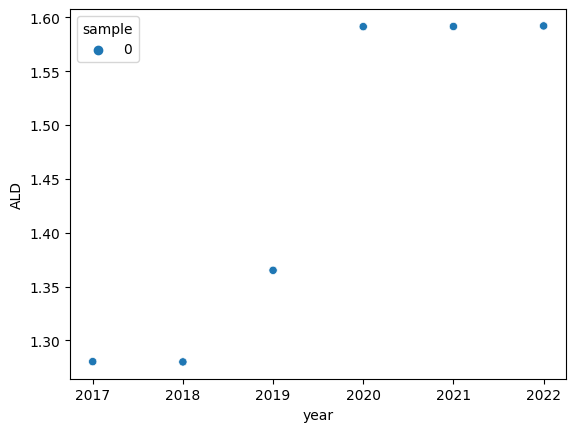

In [30]:

sns.scatterplot(data=sample_dfs.loc[sample_dfs['sample']==0], x='year', y='ALD', hue='sample')

In [31]:
sample_dfs

,date,sample,GPP,RH,ALD,year,month
2017-01-01,2017-01-01,38,0.000000,3.253082,1.057445,2017,1
2017-02-01,2017-02-01,38,0.000000,3.702840,NaN,2017,2
2017-03-01,2017-03-01,38,0.000000,3.754004,NaN,2017,3
2017-04-01,2017-04-01,38,0.000000,4.382988,NaN,2017,4
2017-05-01,2017-05-01,38,200.162401,35.590459,NaN,2017,5
...,...,...,...,...,...,...,...
2022-08-01,2022-08-01,23,422.117920,122.881756,NaN,2022,8
2022-09-01,2022-09-01,23,235.850192,104.497965,NaN,2022,9
2022-10-01,2022-10-01,23,0.000000,60.940515,NaN,2022,10
2022-11-01,2022-11-01,23,0.000000,8.540215,NaN,2022,11


In [44]:
sample_matrix=pd.read_csv(os.path.join(SA_path, 'sample_matrix.csv'))
sample_matrix.iloc[19]

hksat(m)       0.131656
hksat(f)       0.145702
hksat(h)       0.026404
tcsolid(m)     0.362619
tcsolid(f)     0.154402
tcsolid(h)     0.166194
porosity(m)    0.891279
porosity(f)    0.852426
porosity(h)    0.534229
nfactor(s)     1.830249
nfactor(w)     0.245063
rhq10          2.385019
Name: 19, dtype: float64

In [45]:
sample_matrix.iloc[35]

hksat(m)       0.131790
hksat(f)       0.197382
hksat(h)       0.034128
tcsolid(m)     0.237770
tcsolid(f)     0.251886
tcsolid(h)     0.103160
porosity(m)    0.845190
porosity(f)    0.889754
porosity(h)    0.589171
nfactor(s)     1.859984
nfactor(w)     0.348639
rhq10          2.380963
Name: 35, dtype: float64

In [33]:
sample_summary_s = sample_dfs.loc[(sample_dfs['month']>7) & (sample_dfs['month']<9), ['sample', 'GPP', 'RH', 'ALD']].groupby(by='sample').mean()
t_layers_summary_s = t_layers.loc[(t_layers['month']>7) & (t_layers['month']<9), ['sample', 'z', 'type', 'TLAYER']].groupby(by=['sample', 'z']).mean().reset_index()
lwc_layers_summary_s = lwc_layers.loc[(lwc_layers['month']>7) & (lwc_layers['month']<9), ['sample', 'z', 'type', 'LWCLAYER']].groupby(by=['sample', 'z']).mean().reset_index()

sample_summary_s = sample_summary_s.merge(sample_matrix, left_index=True, right_index=True)
sample_summary_s = sample_summary_s.merge(t_layers_summary_s, left_index=True, right_on='sample', how='right')
sample_summary_s = sample_summary_s.merge(lwc_layers_summary_s, on=['sample', 'z'])

sample_summary_w = sample_dfs.loc[(sample_dfs['month']<6) | (sample_dfs['month']>=10), ['sample', 'GPP', 'RH', 'ALD']].groupby(by='sample').mean()
t_layers_summary_w = t_layers.loc[(t_layers['month']<6) | (t_layers['month']>=10), ['sample', 'z', 'type', 'TLAYER']].groupby(by=['sample', 'z']).mean().reset_index()
lwc_layers_summary_w = lwc_layers.loc[(lwc_layers['month']<6) | (lwc_layers['month']>=10), ['sample', 'z', 'type', 'LWCLAYER']].groupby(by=['sample', 'z']).mean().reset_index()

sample_summary_w = sample_summary_w.merge(sample_matrix, left_index=True, right_index=True)
sample_summary_w = sample_summary_w.merge(t_layers_summary_w, left_index=True, right_on='sample', how='right')
sample_summary_w = sample_summary_w.merge(lwc_layers_summary_w, on=['sample', 'z'])

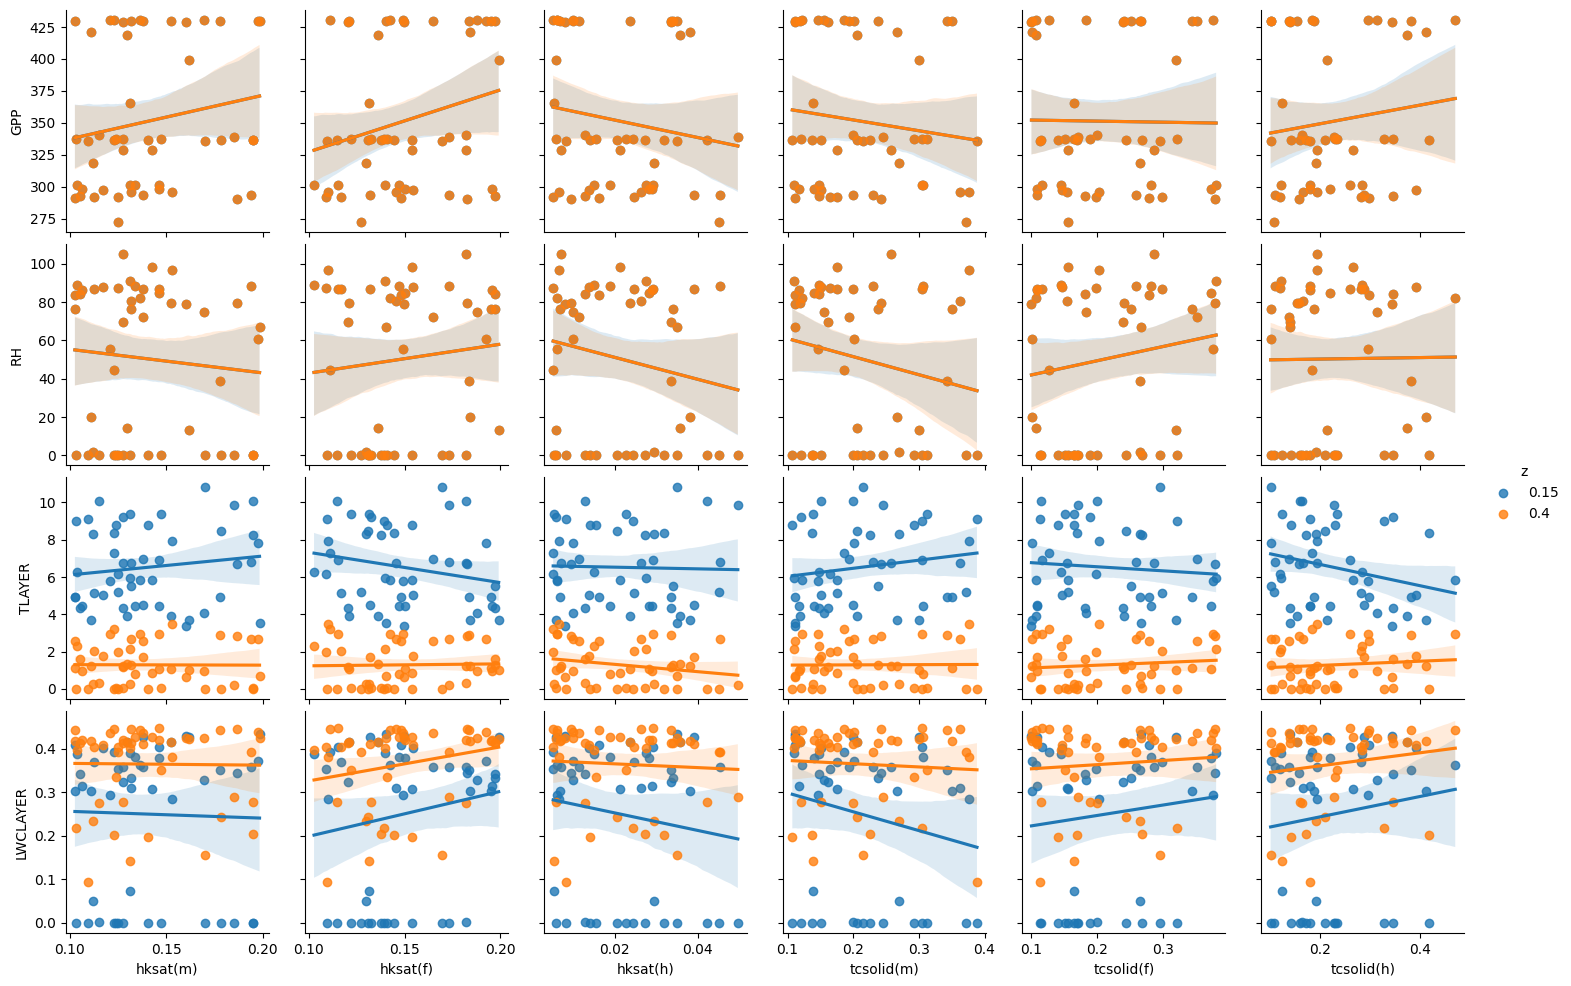

In [34]:
sns.pairplot(data=sample_summary_s, x_vars=['hksat(m)','hksat(f)','hksat(h)',
          'tcsolid(m)', 'tcsolid(f)', 'tcsolid(h)'], y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

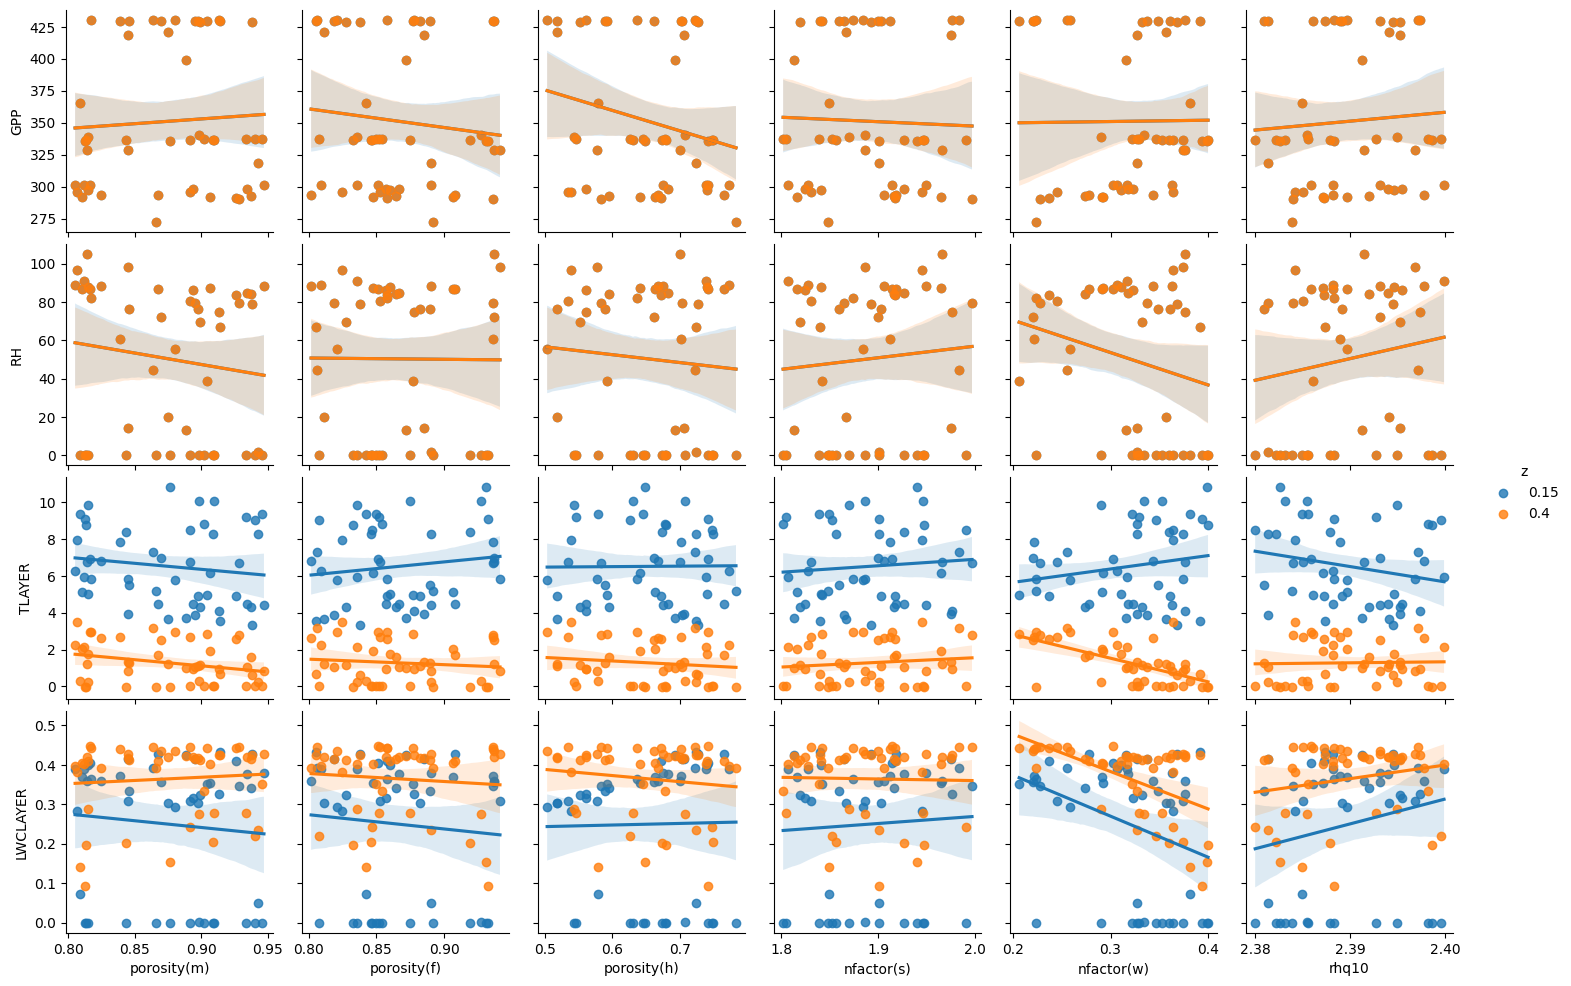

In [35]:
sns.pairplot(data=sample_summary_s, x_vars=['porosity(m)', 'porosity(f)', 'porosity(h)', 'nfactor(s)', 'nfactor(w)', 'rhq10'], 
             y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

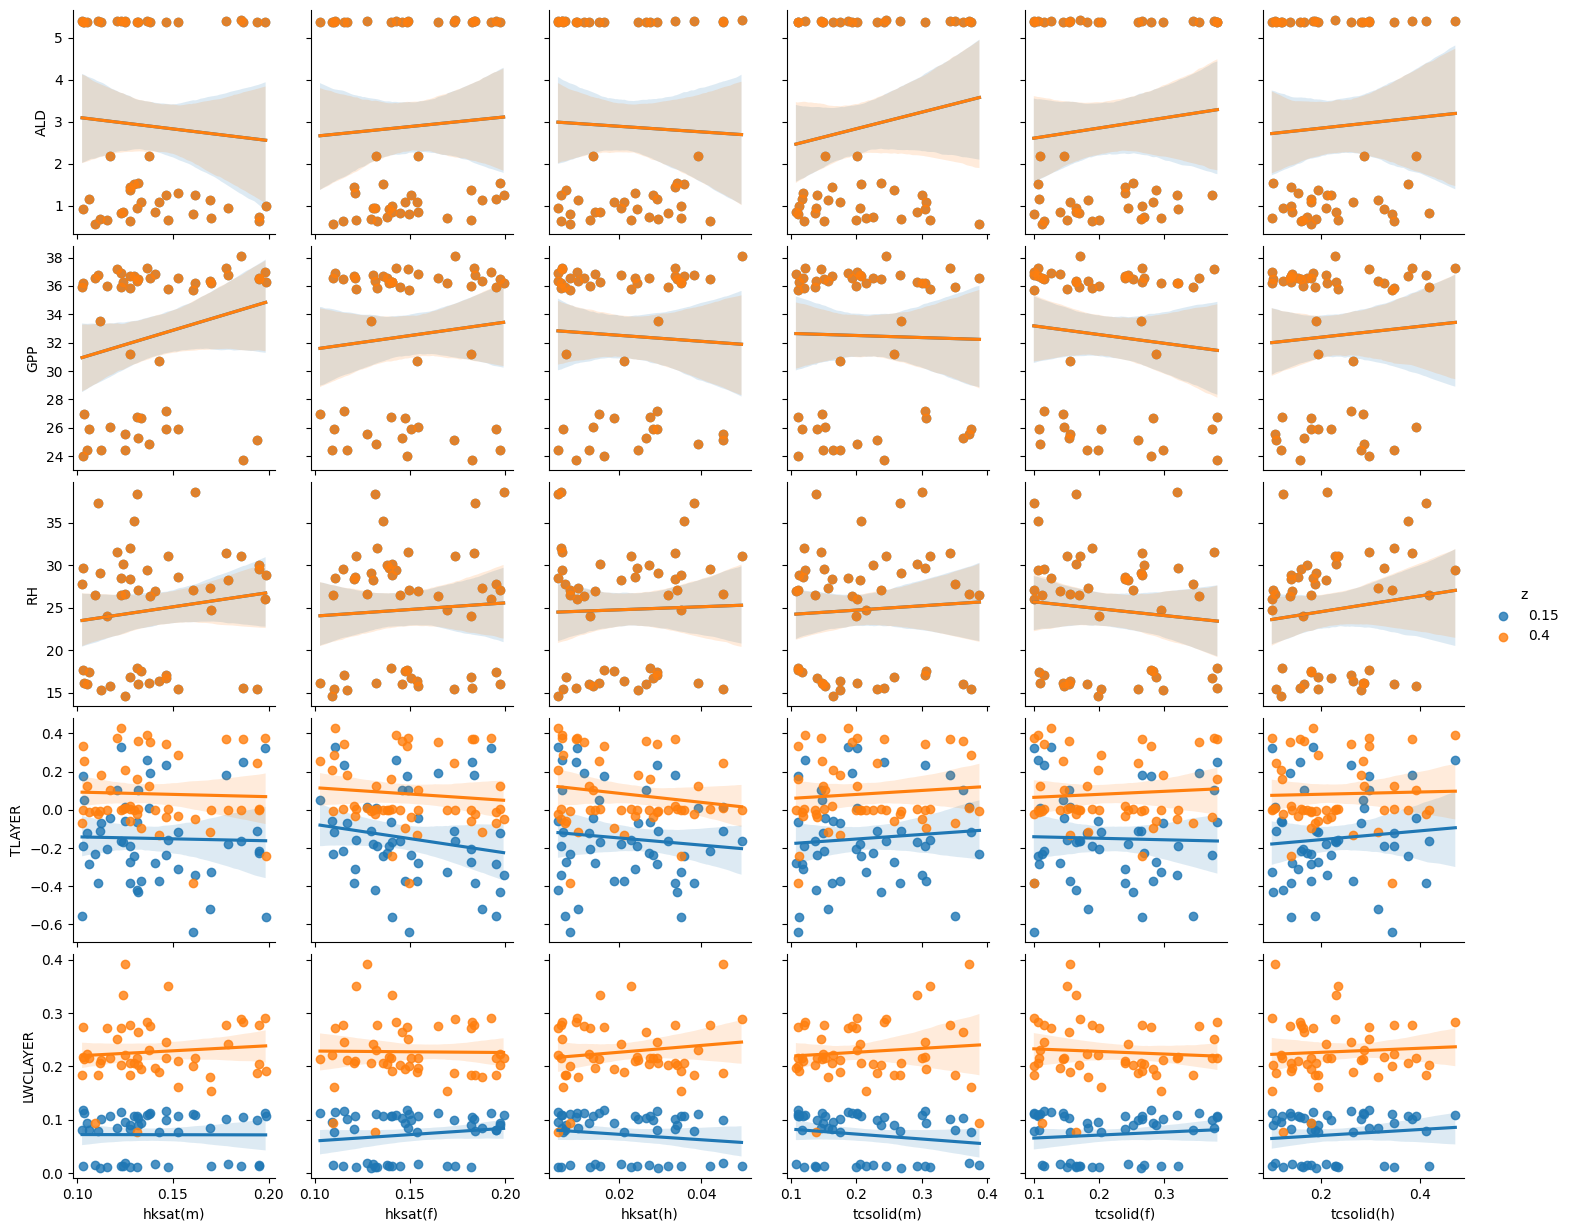

In [19]:
sns.pairplot(data=sample_summary_w, x_vars=['hksat(m)','hksat(f)','hksat(h)',
          'tcsolid(m)', 'tcsolid(f)', 'tcsolid(h)'], y_vars= ['ALD', 'GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

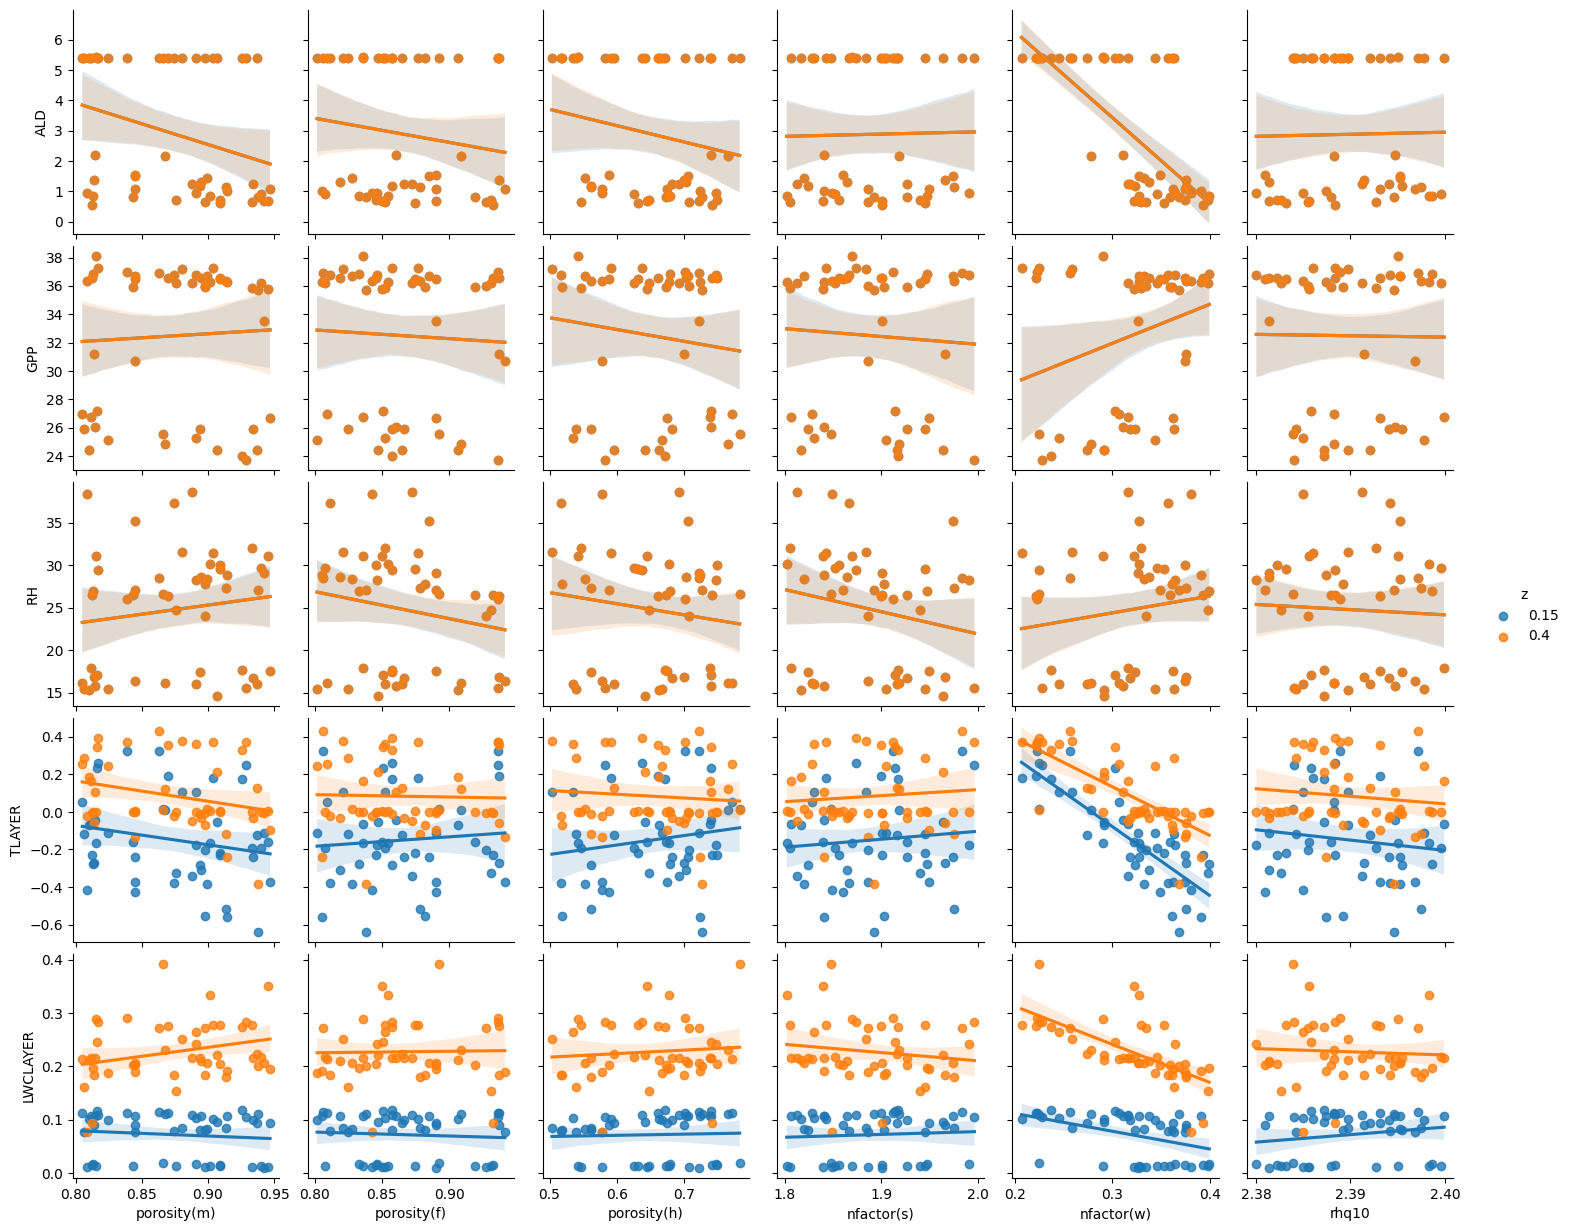

In [20]:
sns.pairplot(data=sample_summary_w, x_vars=['porosity(m)', 'porosity(f)', 'porosity(h)', 'nfactor(s)', 'nfactor(w)', 'rhq10'], 
             y_vars= ['ALD', 'GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

In [21]:
sample_summary_s

,GPP,RH,ALD,hksat(m),hksat(f),hksat(h),tcsolid(m),tcsolid(f),tcsolid(h),porosity(m),...,porosity(h),nfactor(s),nfactor(w),rhq10,sample,z,type_x,TLAYER,type_y,LWCLAYER
0,429.234014,69.721704,NaN,0.127462,0.120601,0.033612,0.162185,0.239349,0.139960,0.899206,...,0.552233,1.819679,0.332061,2.395287,0,0.15,2.0,4.319915,2.0,0.323141
1,429.234014,69.721704,NaN,0.127462,0.120601,0.033612,0.162185,0.239349,0.139960,0.899206,...,0.552233,1.819679,0.332061,2.395287,0,0.40,3.0,1.149294,3.0,0.413433
2,297.819213,86.227959,NaN,0.106072,0.195398,0.029074,0.116635,0.107823,0.181015,0.893700,...,0.561706,1.824277,0.323003,2.395493,1,0.15,2.0,4.449855,2.0,0.315233
3,297.819213,86.227959,NaN,0.106072,0.195398,0.029074,0.116635,0.107823,0.181015,0.893700,...,0.561706,1.824277,0.323003,2.395493,1,0.40,3.0,0.928534,3.0,0.421052
4,301.552823,88.388438,NaN,0.133617,0.147193,0.018728,0.306624,0.282312,0.181338,0.946996,...,0.674727,1.949615,0.362354,2.393130,2,0.15,2.0,4.436406,2.0,0.380498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,340.151257,0.133730,NaN,0.115363,0.182207,0.012779,0.199086,0.200111,0.165190,0.897844,...,0.707748,1.885986,0.334593,2.385508,47,0.40,3.0,0.301549,3.0,0.274302
96,292.930931,83.960061,NaN,0.105057,0.197348,0.012767,0.148303,0.182192,0.347534,0.937495,...,0.595660,1.916440,0.274234,2.392021,48,0.15,2.0,4.320827,2.0,0.341304
97,292.930931,83.960061,NaN,0.105057,0.197348,0.012767,0.148303,0.182192,0.347534,0.937495,...,0.595660,1.916440,0.274234,2.392021,48,0.40,3.0,1.620750,3.0,0.414166
98,337.334079,0.000714,NaN,0.127623,0.132646,0.005821,0.120385,0.188609,0.346936,0.933515,...,0.546338,1.805090,0.329164,2.392738,49,0.15,2.0,9.209378,2.0,0.000000


In [22]:
tripod_data_monthly

,Location,year,month,soil_moisture_15cm(%),soil_moisture_40cm(%),soil_temp_15cm(°C),soil_temp_40cm(°C),PAR(µmol/m²/s),air_temp_1m(°C),day,m_y
0,D13,2021,9,NaN,NaN,NaN,NaN,NaN,-2.504243,1,2021-09-01
1,D13,2021,10,NaN,NaN,NaN,NaN,NaN,-3.134267,1,2021-10-01
2,D13,2021,11,NaN,NaN,NaN,NaN,NaN,-18.891440,1,2021-11-01
3,D13,2021,12,NaN,NaN,NaN,NaN,NaN,-18.087169,1,2021-12-01
4,D13,2022,1,NaN,NaN,NaN,NaN,NaN,-20.166466,1,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...
58,WTT3,2022,4,0.210298,0.184463,-0.961724,-0.650803,213.892708,NaN,1,2022-04-01
59,WTT3,2022,5,0.376718,0.267047,0.220679,-0.004485,193.718481,NaN,1,2022-05-01
60,WTT3,2022,6,0.338398,0.309971,NaN,NaN,98.845833,NaN,1,2022-06-01
61,WTT3,2022,7,0.263860,0.282005,10.547886,9.108664,62.668414,NaN,1,2022-07-01


In [23]:
tlayer_merged = t_layers[['time', 'z', 'TLAYER', 'sample']].merge(tripod_data_monthly[['m_y', 'soil_temp_15cm(°C)', 'soil_temp_40cm(°C)']], left_on = ['time'], right_on=['m_y'], how='left')
tlayer_merged= tlayer_merged.loc[~tlayer_merged['soil_temp_15cm(°C)'].isna() & ~tlayer_merged['soil_temp_40cm(°C)'].isna() & ~tlayer_merged['TLAYER'].isna()]

lwclayer_merged = lwc_layers[['time', 'z', 'LWCLAYER', 'sample']].merge(tripod_data_monthly[['m_y', 'soil_moisture_15cm(%)', 'soil_moisture_40cm(%)']], left_on = ['time'], right_on=['m_y'], how='left')
lwclayer_merged= lwclayer_merged.loc[~lwclayer_merged['soil_moisture_15cm(%)'].isna() & ~lwclayer_merged['soil_moisture_40cm(%)'].isna() & ~lwclayer_merged['LWCLAYER'].isna()]

In [24]:
r2s_15cm = []
r2s_40cm = []

samples = []

for sample in tlayer_merged['sample'].unique():
    
    tlayer_sample = tlayer_merged.loc[tlayer_merged['sample']==sample]
    if len(tlayer_sample.loc[tlayer_sample['z']==0.15])>0:
        r2_15cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.15, 'soil_temp_15cm(°C)'], tlayer_sample.loc[tlayer_sample['z']==0.15, 'TLAYER'])
        r2_40cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.4, 'soil_temp_40cm(°C)'], tlayer_sample.loc[tlayer_sample['z']==0.4, 'TLAYER'])

        samples.append(sample)
        r2s_15cm.append(r2_15cm)
        r2s_40cm.append(r2_40cm)
    
df_tlayer = pd.DataFrame({'sample': samples, 'r2_15cm': r2s_15cm, 'r2_40cm': r2s_40cm})

In [25]:
lwclayer_r2s_15cm = []
lwclayer_r2s_40cm = []

samples = []
for sample in tlayer_merged['sample'].unique():
    lwclayer_sample = lwclayer_merged.loc[lwclayer_merged['sample']==sample]
    if len(lwclayer_sample.loc[lwclayer_sample['z']==0.15])>0:
        r2_15cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.15, 'soil_moisture_15cm(%)'], lwclayer_sample.loc[lwclayer_sample['z']==0.15, 'LWCLAYER'])
        r2_40cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.4, 'soil_moisture_40cm(%)'], lwclayer_sample.loc[lwclayer_sample['z']==0.4, 'LWCLAYER'])

        samples.append(sample)
        lwclayer_r2s_15cm.append(r2_15cm)
        lwclayer_r2s_40cm.append(r2_40cm)
    
df_lwclayer = pd.DataFrame({'sample': samples, 'r2_15cm': lwclayer_r2s_15cm, 'r2_40cm': lwclayer_r2s_40cm})

In [26]:
df_tlayer.sort_values('r2_15cm', ascending=False).head(20)

,sample,r2_15cm,r2_40cm
48,37,0.631684,-0.481911
7,19,0.551394,-0.492209
32,36,0.537837,-0.488434
38,5,0.503000,-0.477159
27,17,0.500638,-0.484448
29,27,0.454421,-0.480018
13,35,0.396030,-0.490911
47,14,0.325792,-0.495534
44,28,0.313976,-0.485466
19,0,0.313708,-0.492180


In [27]:
df_lwclayer.sort_values('r2_15cm', ascending=False).head(20)

,sample,r2_15cm,r2_40cm
24,46,-2.445941,-10.288726
7,19,-2.464317,-10.735266
8,11,-2.525109,-10.696133
18,21,-2.528777,-10.217513
19,0,-2.564247,-10.980120
14,1,-2.595161,-10.889999
38,5,-2.603949,-8.235324
47,14,-2.604782,-10.432232
15,22,-2.651213,-10.186928
13,35,-2.718643,-10.855803
